In [1]:
%pylab inline 


Populating the interactive namespace from numpy and matplotlib


In [2]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding
from collections import Counter
import time
import progressbar as pb
from tqdm import tqdm
import os
import shutil
from empyrical import sortino_ratio, calmar_ratio, omega_ratio
from stable_baselines.common.policies import MlpPolicy, MlpLstmPolicy
from stable_baselines.common.vec_env import SubprocVecEnv, VecEnv, VecEnvWrapper
from stable_baselines import A2C, PPO2
from stable_baselines.common.vec_env import DummyVecEnv

import progressbar as pb

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, LSTM, Reshape, Dropout, Input, Concatenate
from keras.optimizers import Adam

from rl.agents.cem import CEMAgent 
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory, EpisodeParameterMemory
from rl.processors import WhiteningNormalizerProcessor
from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess

from trading_env import TradingEnv

Using TensorFlow backend.


In [3]:
# load the market data
input_source = np.load(open('data_eurusd2.npy','rb'))
to_predict = np.load(open('data_eurusd2_targets.npy','rb'))

to_predict = to_predict[3,:].reshape(-1)

input_source = input_source.T

In [4]:
is_orig = np.copy(input_source)
cp = int(0.8*len(input_source))
test_input_source = input_source[cp:, :]
test_to_predict = to_predict[cp:]
input_source = input_source[0:cp, :]
to_predict = to_predict[0:cp]

In [5]:
bars_per_episode = 1000
winlen = 1
traded_amt = 1000
commission = 0
slippage = 0.0

In [6]:
# multiprocess environment
#n_cpu = 16
#env = SubprocVecEnv([lambda: TradingEnv() for i in range(n_cpu)])
env = TradingEnv(input_source, to_predict,
                 winlen=winlen, bars_per_episode=bars_per_episode, traded_amt=traded_amt,
                 commission=commission, slippage=slippage,
                 reward_type='cur_balance',
                 min_ratio_trades = 20,
                 max_position_time = 30,
                 )

In [7]:
# Next, we build a very simple model.
actor = Sequential()
actor.add(Reshape(env.observation_space.shape, input_shape=(1,) + env.observation_space.shape))
#actor.add(LSTM(16))
#actor.add(Dropout(0.5))
actor.add(Dense(32))
actor.add(Dense(32))
actor.add(Dense(32))
actor.add(Activation('relu'))
actor.add(Dense(env.action_space.n, activation='tanh'))
print(actor.summary())

action_input = Input(shape=(env.action_space.n,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Dense(64)(flattened_observation)
x = Activation('relu')(x)
x = Concatenate()([x, action_input])
x = Dense(64)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

W0711 16:21:57.269747 140498664552256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0711 16:21:57.271239 140498664552256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0711 16:21:57.277593 140498664552256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 181)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                5824      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 8,035
Trainable params: 8,035
Non-trainable params: 0
_________________________________________________________________
None
___

In [8]:
memory = SequentialMemory(limit=10000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=env.action_space.n, theta=.15, mu=0., sigma=.1)
agent = DDPGAgent(nb_actions=env.action_space.n, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=10, nb_steps_warmup_actor=10,
                  random_process=random_process, gamma=.99, target_model_update=1e-3,
                  processor=WhiteningNormalizerProcessor()
                 )
agent.compile([Adam(lr=1e-4), Adam(lr=1e-3)], metrics=['mae'])

W0711 16:21:57.421003 140498664552256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0711 16:21:57.421578 140498664552256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0711 16:21:57.558951 140498664552256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [9]:
# training is here
h = agent.fit(env, nb_steps=500000, nb_max_episode_steps=bars_per_episode, visualize=False, verbose=1)
rewards = h.history['episode_reward']

Training for 500000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 34s 3ms/step - reward: -0.0126
10 episodes - episode_reward: -12.617 [-195.980, 142.880] - loss: 0.712 - mean_absolute_error: 0.772 - mean_q: 0.502

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 38s 4ms/step - reward: 0.0346
10 episodes - episode_reward: 34.637 [-456.350, 479.280] - loss: 2.358 - mean_absolute_error: 1.342 - mean_q: 0.859

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 39s 4ms/step - reward: 0.0648
10 episodes - episode_reward: 64.802 [-247.100, 217.850] - loss: 3.161 - mean_absolute_error: 1.414 - mean_q: 2.441

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 39s 4ms/step - reward: 0.1464
10 episodes - episode_reward: 146.431 [-75.930, 369.820] - loss: 2.650 - mean_absolute_error: 1.276 - mean_q: 3.308

Interval 5 (40000 steps performed)
10000/10000 [========

10000/10000 [==============================] - 35s 4ms/step - reward: 0.0413
10 episodes - episode_reward: 41.258 [-12.210, 180.680] - loss: 0.891 - mean_absolute_error: 0.737 - mean_q: 12.459

Interval 37 (360000 steps performed)
10000/10000 [==============================] - 35s 3ms/step - reward: 0.0331
10 episodes - episode_reward: 33.074 [-13.570, 114.870] - loss: 0.538 - mean_absolute_error: 0.547 - mean_q: 11.618

Interval 38 (370000 steps performed)
10000/10000 [==============================] - 34s 3ms/step - reward: 0.0280
10 episodes - episode_reward: 28.026 [-123.660, 219.900] - loss: 0.507 - mean_absolute_error: 0.524 - mean_q: 10.685

Interval 39 (380000 steps performed)
10000/10000 [==============================] - 36s 4ms/step - reward: 0.0478
10 episodes - episode_reward: 47.841 [-4.920, 116.760] - loss: 0.549 - mean_absolute_error: 0.589 - mean_q: 10.527

Interval 40 (390000 steps performed)
10000/10000 [==============================] - 35s 3ms/step - reward: 0.0642

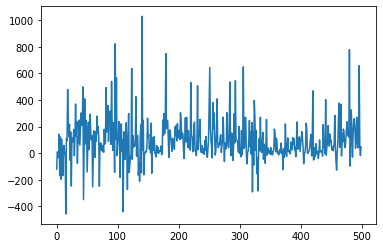

In [10]:
plot(rewards);

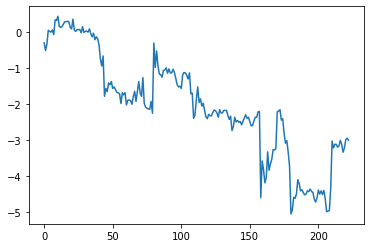

In [15]:
env = TradingEnv(test_input_source, test_to_predict,
                 winlen=winlen, bars_per_episode=bars_per_episode, traded_amt=traded_amt,
                 commission=commission, slippage=slippage,
                 reward_type='cur_balance',
                 min_ratio_trades = 20,
                 max_position_time = 30,
                 )
# visualize the behavior for one random episode
bars_per_episode = 1000

observation = env.reset()
done = False
navs = []
while not done:
    action = agent.forward(observation)
    observation, reward, done, info = env.step(action)
navs = env.returns

kl = []
t = 0
for n in navs:
    t += n
    kl.append(t)
plot(kl);

 32% (3219 of 10000) |######             | Elapsed Time: 0:19:15 ETA:   0:47:06

Profit likelihood: 45.169%


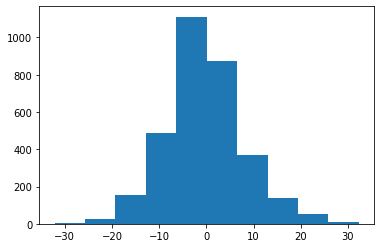

In [12]:
# calculate the likelihood of success for any given episode
try:
    # calculate the likelihood of success for any given episode
    l = 10000
    krl = []
    p = pb.ProgressBar(max_value=l)
    for i in range(l):
        p.update(i)
        observation = env.reset()
        done = False
        navs = []
        while not done:
            action = agent.forward(observation)
            observation, reward, done, info = env.step(action)
        krl.append(sum(env.returns))
    p.finish()
except KeyboardInterrupt:
    pass

krl = np.array(krl)
print('Profit likelihood: %3.3f%%' % (100*(sum(krl > 0) / len(krl))))

hist(krl);